<a id='0'></a>
# <p style="background-color:blue; font-family:newtimeroman; font-size:100%; text-align:center; border-radius: 15px 50px; color:white;">Please upvote the notebook as well if you find it useful and forking the notebook🎯 </p>

<a id='0'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Coleridge Initiative🖋📝 - EDA📚 & Baseline Model🎯 </p>

# <p style="font-family:newtimeroman; text-align:center; fontsize:150%">Coleridge Initiative - Show US the Data<br>Discover how data is used for the public good</p>
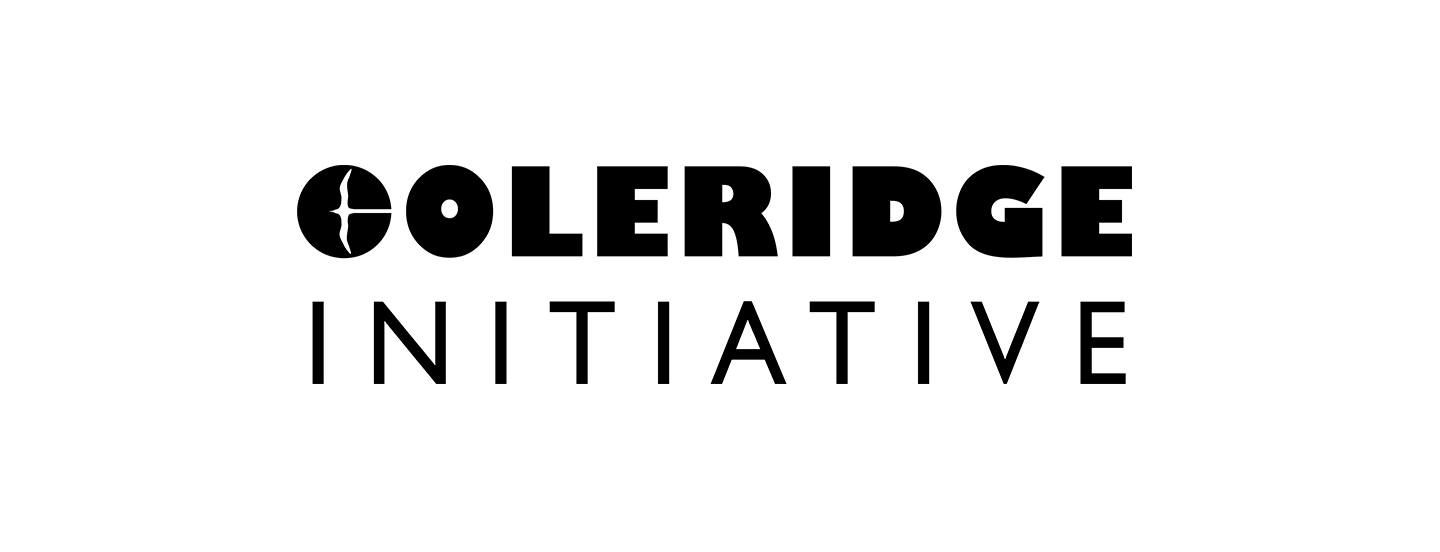

## Hey There! 🙌🏻🙋🏻‍♂️
In this notebook basically we have to predict text for some strings by using nlp techniques.
*** 
>The objective of the competition is to identify the mention of datasets within scientific publications.

This competition challenges data scientists to show how publicly funded data are used to serve science and society. Evidence through data is critical if government is to address the many threats facing society, including; pandemics, climate change, Alzheimer’s disease, child hunger, increasing food production, maintaining biodiversity, and addressing many other challenges. Yet much of the information about data necessary to inform evidence and science is locked inside publications.

The Coleridge Initiative is a not-for-profit organization originally established at New York University. It was set up in order to inform the decision-making of the Commission on Evidence-based Policymaking and has since worked with dozens of government agencies at the federal, state, and local levels to ensure that data are more effectively used for public decision-making.

It achieves this goal by working with the agencies to create value for the taxpayer from the careful use of data by building new technologies to enable secure access to and sharing of confidential microdata and by training agency staff to acquire modern data skills.

### Special thanks to helper notebooks 🙏🏻:- 
1. [Tabular Data Preparation, Basic EDA and Baseline](https://www.kaggle.com/manabendrarout/tabular-data-preparation-basic-eda-and-baseline)
2. [Coleridge - Data Loading, EDA & Simple Submission](https://www.kaggle.com/poornap/coleridge-data-loading-eda-simple-submission)
3. [Coleridge Initiative - EDA + Naïve Submission 📚](https://www.kaggle.com/josephassaker/coleridge-initiative-eda-na-ve-submission/data)

<a id='1'></a>
# <p style="background-color:red; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 10px 25px;">Table of Content</p>
* [1. Importing necessary modules and libraries📚](#1)
* [2. Data Exploration🔍](#2)
* [3. Data Cleaning🔧](#3)
* [4. Data Vizualization🎨](#4)
* [5. Baseline model and Submission📝](#5)

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">1. Importing necessary modules and libraries📚</p>

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import nltk
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 4000000
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

from tqdm.autonotebook import tqdm
import string

%matplotlib inline

os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')

['sample_submission.csv', 'train.csv', 'test', 'train']

We are provided with 4 main pieces of data:

* `train.csv:` The CSV file containing all the metadata of the publications, such as their title and the dataset they utilize.
* `train:` The directory containing the actual publications that are referenced in train.csvin JSON format.
* `test:` The directory containing the actual publications that will be used for testing purposes (thus, with no ground truth CSV file available).
* `sample_submission.csv:` The CSV file containing all the publications IDs in the test set, for which we'll have to populate the prediction column.

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Data Exploration🔍</p>

In [2]:
# reading csv files and train & test file paths
train_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
sample_sub = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_files_path = '../input/coleridgeinitiative-show-us-the-data/test'

In [3]:
train_df.head(6)

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
5,81b5f874-9b42-4d4f-8c50-b4bab24f8aed,The Gender Gap Reloaded: Are School Characteri...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


<a id='1'></a>
## <p style="text-align:center;">Data Description</p>
train.csv - labels and metadata for the training set train/test directory - the full text of the training/test set's publications in JSON format, broken into sections with section titles

* `id` - publication id - note that there are multiple rows for some training documents, indicating multiple mentioned datasets.
* `pub_title` - title of the publication (a small number of publications have the same title).
* `dataset_title` - the title of the dataset that is mentioned within the publication.
* `dataset_label` - a portion of the text that indicates the dataset.
* `cleaned_label` - the dataset_label, as passed through the clean_text function from the Evaluation page.

sample_submission.csv - a sample submission file in the correct format.
* `Id` - publication id.
* `PredictionString` - To be filled with equivalent of cleaned_label of train data.

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19661 entries, 0 to 19660
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             19661 non-null  object
 1   pub_title      19661 non-null  object
 2   dataset_title  19661 non-null  object
 3   dataset_label  19661 non-null  object
 4   cleaned_label  19661 non-null  object
dtypes: object(5)
memory usage: 768.1+ KB


Great! we don't have any null values.

In [5]:
[print(f"{col}:{len(train_df[col].unique())}") for col in train_df.columns]   #finding unique values in each column

Id:14316
pub_title:14271
dataset_title:45
dataset_label:130
cleaned_label:130


[None, None, None, None, None]

In [6]:
def read_append_return(filename, train_files_path=train_files_path, output='text'):
    """
    Function to read json file and then return the text data from them and append to the dataframe
    """
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [7]:
%%time
tqdm.pandas()   #tqdm is used to show any code running with a progress bar. 
train_df['text'] = train_df['Id'].progress_apply(read_append_return)

  0%|          | 0/19661 [00:00<?, ?it/s]

CPU times: user 9.28 s, sys: 3.84 s, total: 13.1 s
Wall time: 1min 31s


In [8]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,", stress satisfactory outcomes for all youth,..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1. Accountin...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This article investigates an important factor ...


We have our text appended in our train dataframe.

In [9]:
%%time
tqdm.pandas()
sample_sub['text'] = sample_sub['Id'].progress_apply(partial(read_append_return, train_files_path=test_files_path))

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 30.1 ms, sys: 4.16 ms, total: 34.2 ms
Wall time: 55.6 ms


Also, we have the text of for the sample_submission file

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Data Cleaning🔧</p>

In [10]:
def text_cleaning(text):
    '''
    Converts all text to lower case, Removes special charecters, emojis and multiple spaces
    text - Sentence that needs to be cleaned
    '''
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('r[^\w\s]', ' ', str(text).lower()).strip()
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    text = lem.lemmatize(text)
#     text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
#     text = re.sub("/'+/g", ' ', text)
    
    return text

In [11]:
%%time
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(text_cleaning)

  0%|          | 0/19661 [00:00<?, ?it/s]

CPU times: user 1min 46s, sys: 1.68 s, total: 1min 47s
Wall time: 1min 47s


It takes time!🙄

In [12]:
# %%time 
# tqdm.pandas()
# sample_sub['text'] = sample_sub['text'].progress_apply(text_cleaning)

We have our data cleaned!

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Data Vizualization🎨</p>

In [13]:
words =list( train_df['cleaned_label'].values)
stopwords=['ourselves', 'hers','the','of','and','in', 'between', 'yourself', 'but', 'again','of', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

### 100 Most common words (cleaned_label) - WordCloud

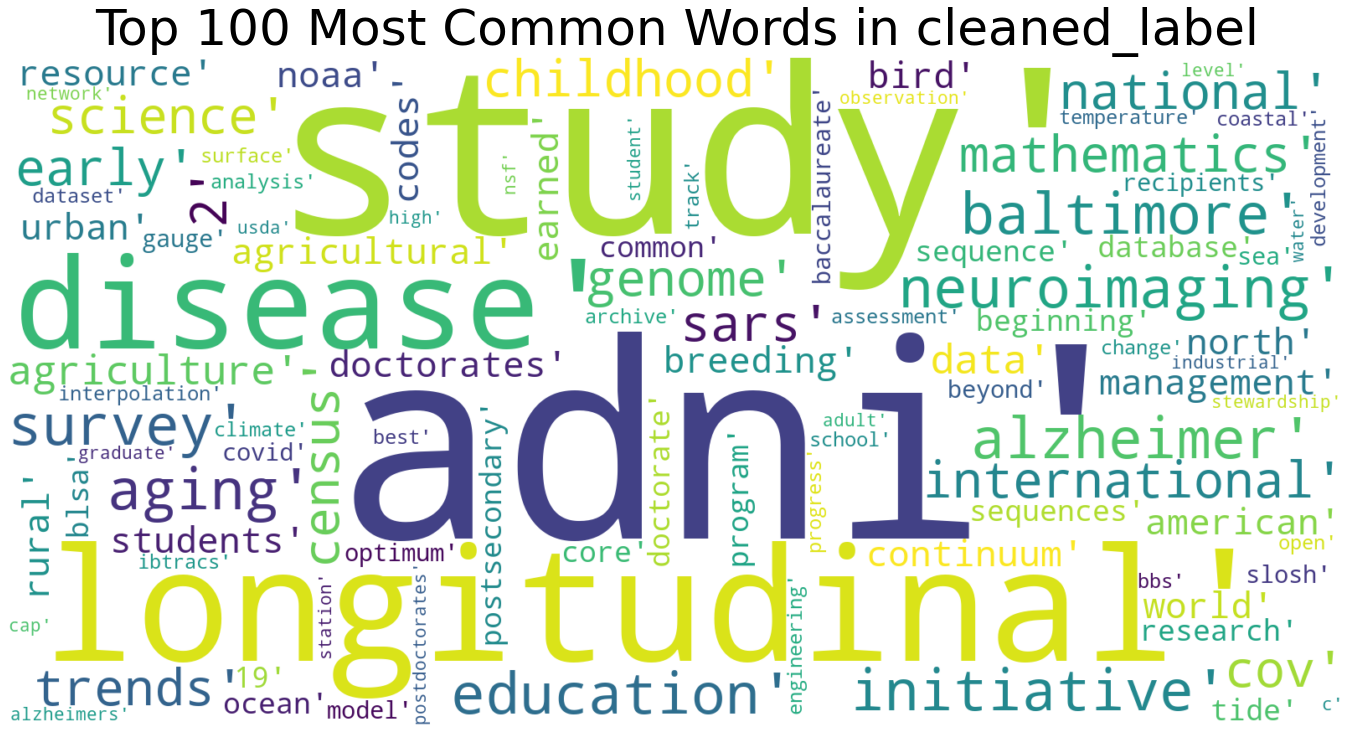

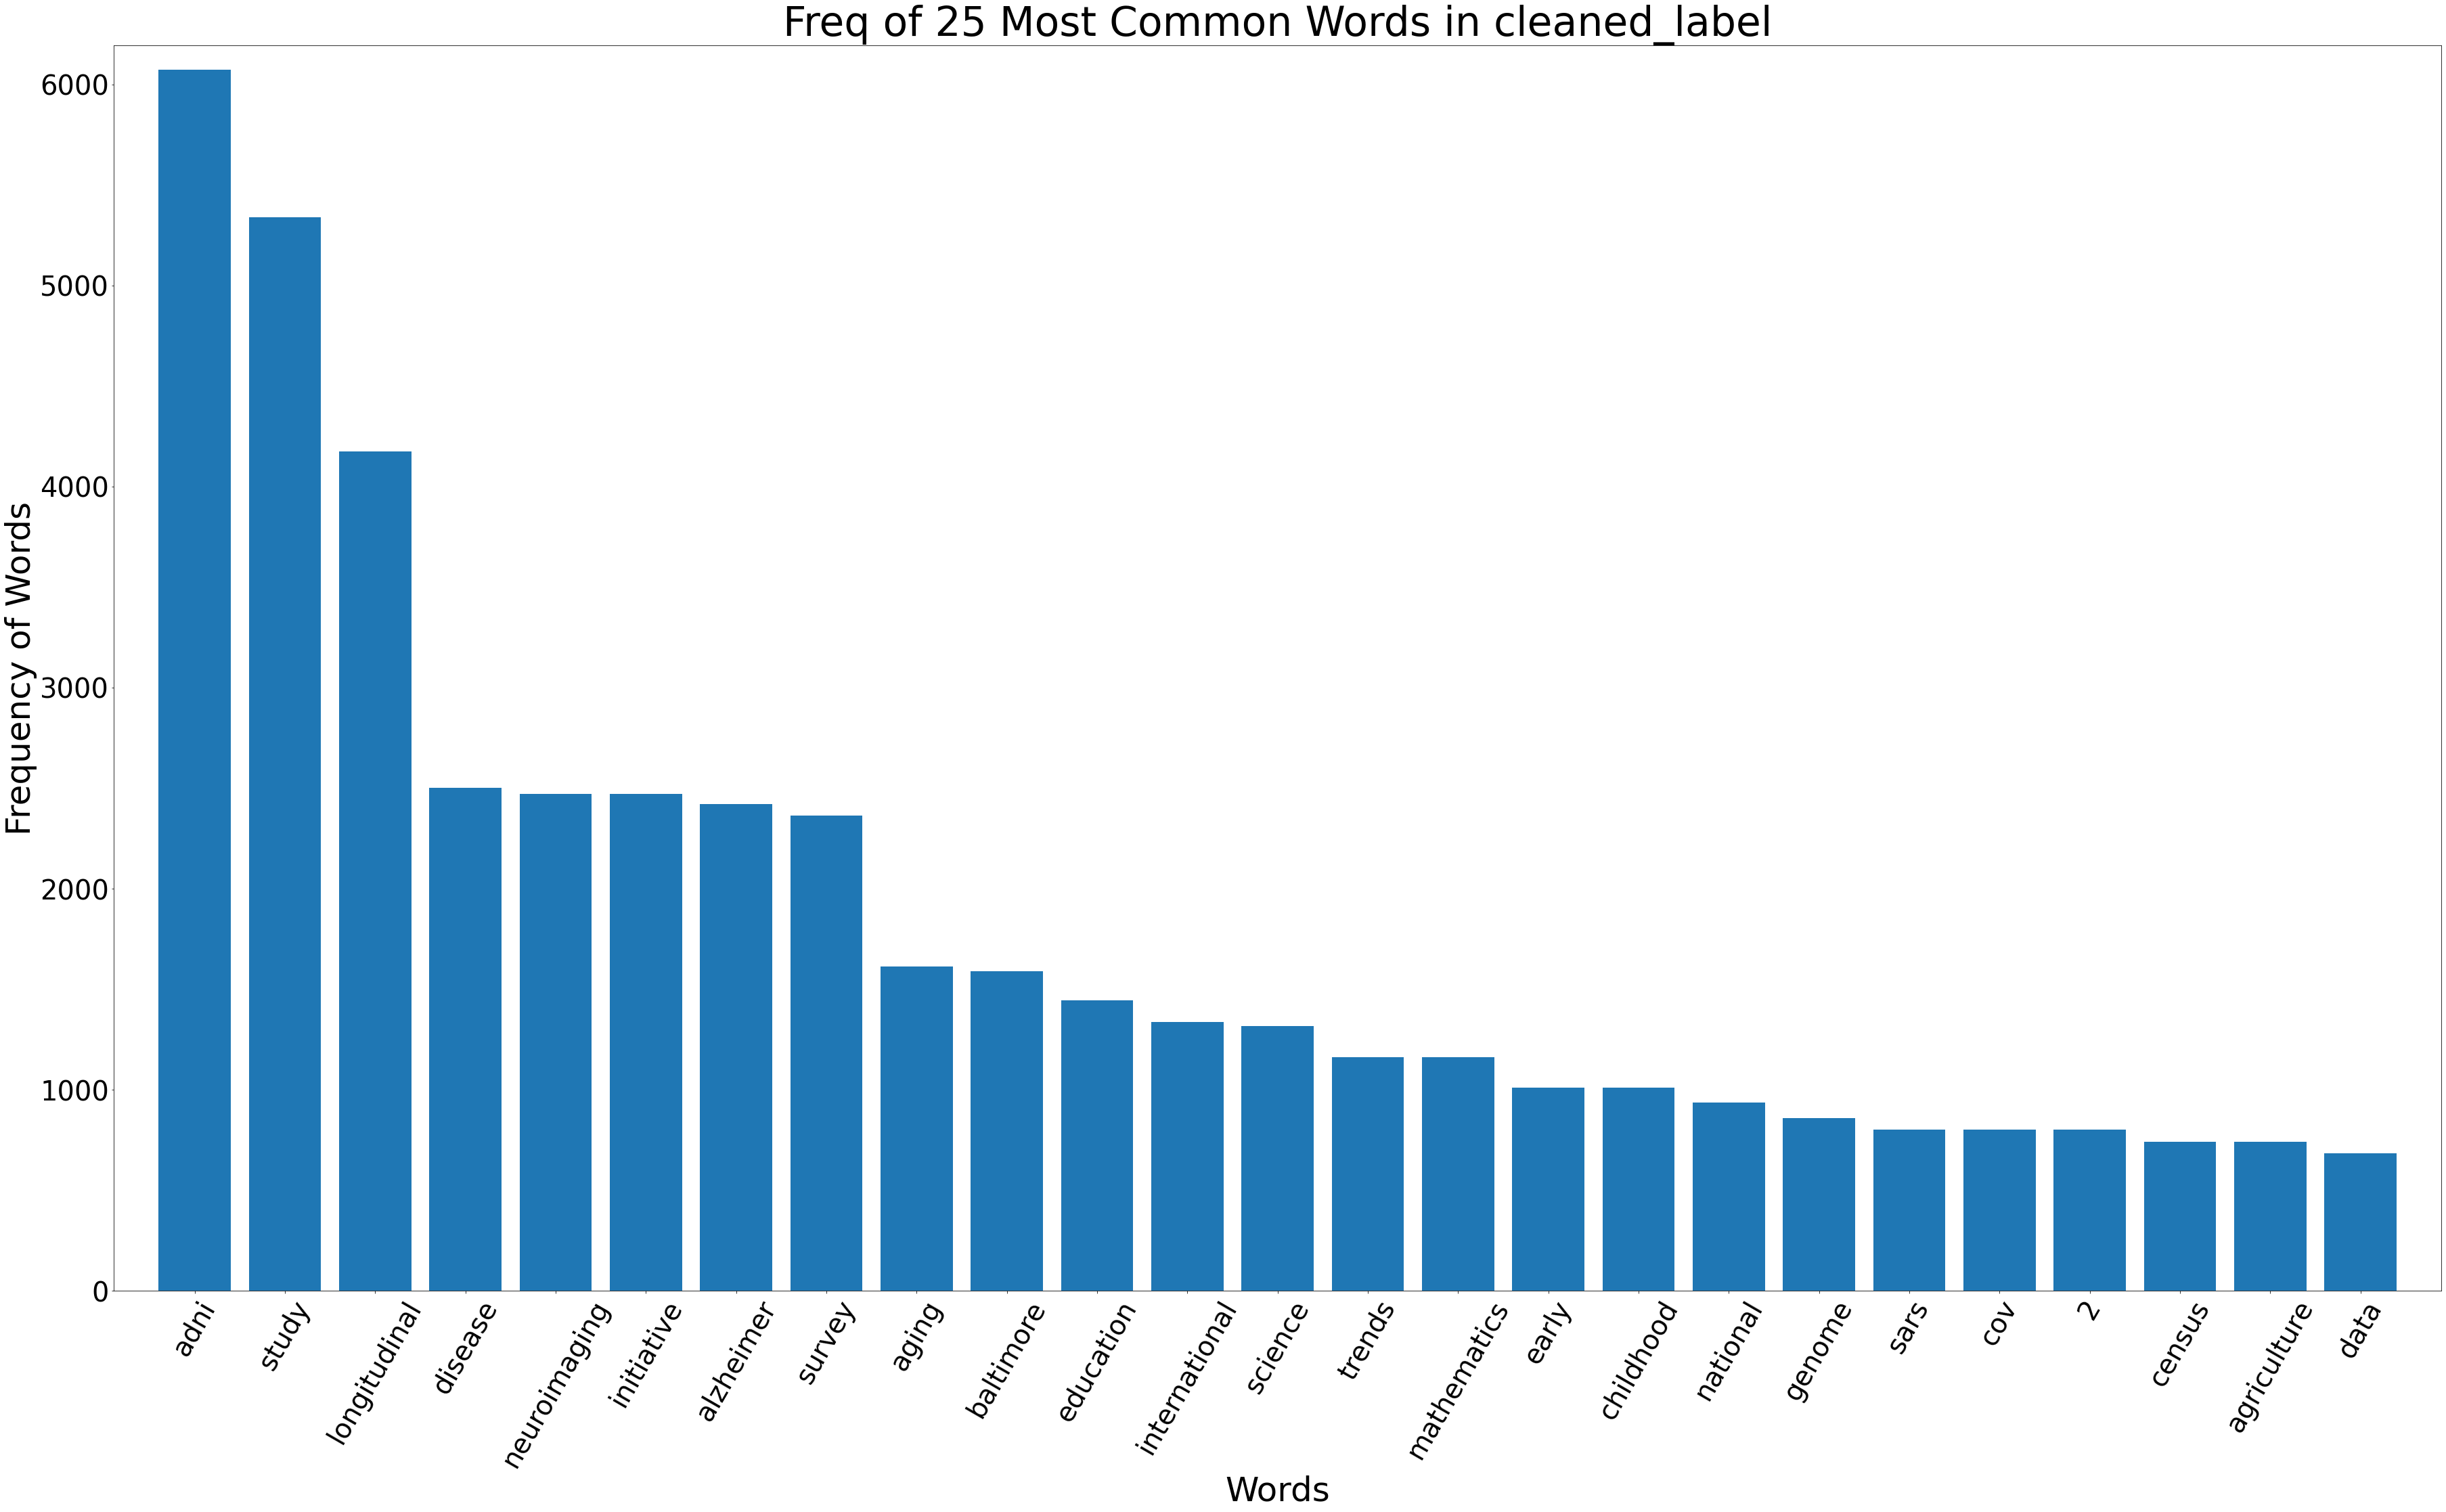

In [14]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white', stopwords=STOPWORDS).generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in cleaned_label', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('Freq of 25 Most Common Words in cleaned_label', fontsize=60)
plt.show()

In [15]:
# def prepare_text(text, nlp=nlp):
#     '''
#     Returns the text after stop-word removal and lemmatization.
#     text - Sentence to be processed
#     nlp - Spacy NLP model
#     '''
#     doc = nlp(text)
#     lemma_list = [token.lemma_ for token in doc if not token.is_stop]
#     lemmatized_sentence = ' '.join(lemma_list)
    
#     return lemmatized_sentence

In [16]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

In [17]:
# %%time
# tqdm.pandas()
# train_df['text'] = train_df['text'].progress_apply(prepare_text)

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Baseline model and Submission📝</p>

In [18]:
temp_1 = [x.lower() for x in train_df['dataset_label'].unique()]
temp_2 = [x.lower() for x in train_df['dataset_title'].unique()]
temp_3 = [x.lower() for x in train_df['cleaned_label'].unique()]

existing_labels = set(temp_1 + temp_2 + temp_3)
id_list = []
lables_list = []
for index, row in tqdm(sample_sub.iterrows()):
    sample_text = row['text']
    row_id = row['Id']
    temp_df = train_df[train_df['text'] == text_cleaning(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    for known_label in existing_labels:
        if known_label in sample_text.lower():
            cleaned_labels.append(clean_text(known_label))
    cleaned_labels = [clean_text(x) for x in cleaned_labels]
    cleaned_labels = set(cleaned_labels)
    lables_list.append('|'.join(cleaned_labels))
    id_list.append(row_id)

|          | 0/? [00:00<?, ?it/s]

In [19]:
submission = pd.DataFrame()
submission['Id'] = id_list
submission['PredictionString'] = lables_list

In [20]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
submission.head()

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,alzheimer s disease neuroimaging initiative ad...
1,2f392438-e215-4169-bebf-21ac4ff253e1,nces common core of data|common core of data|t...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,slosh model|noaa storm surge inundation|sea la...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


In [21]:
submission.to_csv('submission.csv', index=False)

## Hurray! We are done with the submission and model. Hope you like this kernel. If so, don't forget to upvote and leave your valuable comment. Thank you😊